# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os
import librosa
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns

In [3]:
audio_folder = '/content/drive/MyDrive/unlabelled_sounds'
audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

features = []
for file in audio_files:
    y, sr = librosa.load(os.path.join(audio_folder, file), duration=5)  # Load 5-second clips
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    feature_vector = np.mean(mfcc.T, axis=0)
    features.append(feature_vector)

features = np.array(features)
print('Feature matrix shape:', features.shape)

Feature matrix shape: (3000, 13)


## Step 2: Dimensionality Reduction - PCA & t-SNE

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


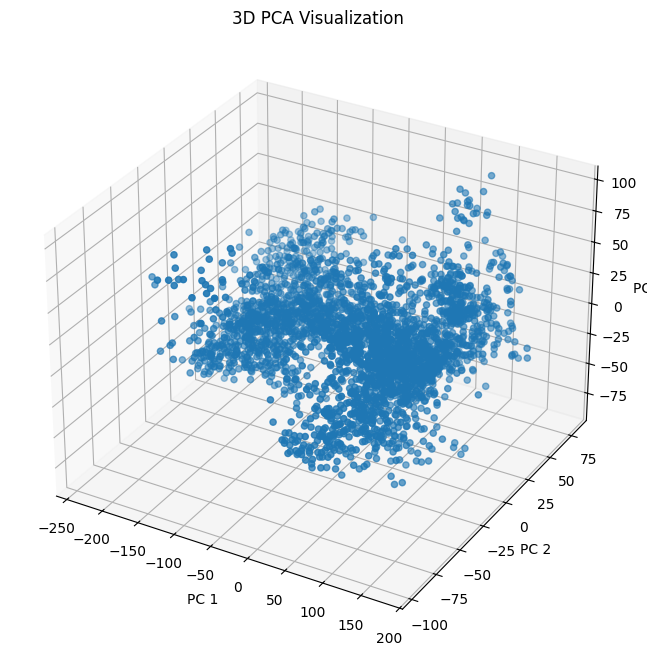

In [7]:

# PCA (3 components)
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
features_pca = pca.fit_transform(features)

# t-SNE (3 components)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)
features_tsne = tsne.fit_transform(features)

# 3D Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2])
ax.set_title('3D PCA Visualization')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

### Why is dimensionality reduction important?
Dimensionality reduction is important because it helps us make sense of complex data by turning it into something we can actually see and work with. In this case, the audio features had many dimensions, and without reducing them, it would have been impossible to plot or understand the patterns.

Challenges faced: When using PCA, many points still overlapped, which made it hard to clearly separate clusters. Also, running t-SNE took a long time and needed careful adjustments to get useful results without errors.

### Which method (PCA or t-SNE) provides better separability of clusters and why?
t-SNE did a better job at separating the clusters compared to PCA. In the PCA 3D plot, most of the points were packed closely together, making it hard to tell the groups apart. This happens because PCA tries to keep the overall shape of the data but doesn’t always show the smaller details that help us spot clusters.
t-SNE, on the other hand, focuses on keeping nearby points close and spreads out different groups, which makes it easier to see clear clusters.



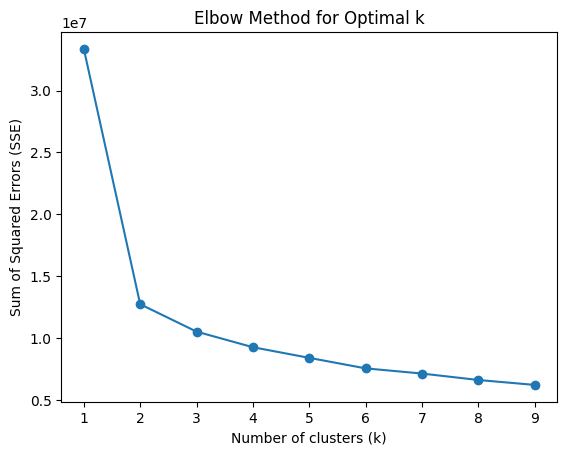

In [13]:

# Optimize number of clusters using Elbow Method
sse = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

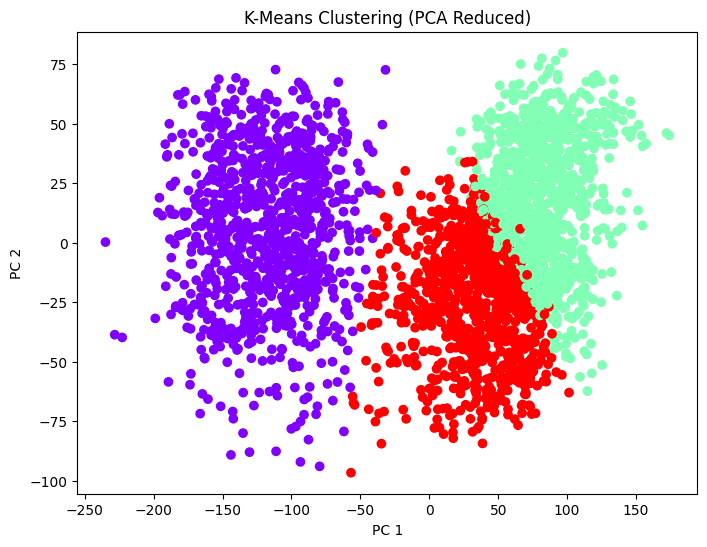

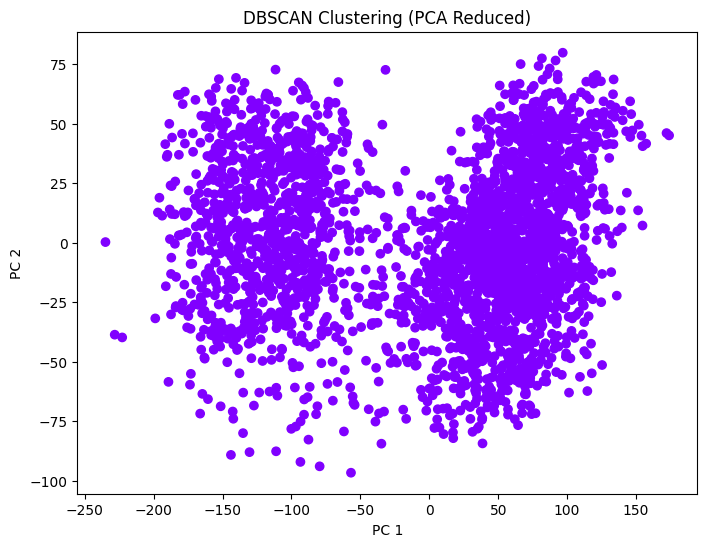

In [14]:

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='rainbow')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('K-Means Clustering (PCA Reduced)')
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='rainbow')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('DBSCAN Clustering (PCA Reduced)')
plt.show()

In [16]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.3168, Davies-Bouldin Index: 1.3631
DBSCAN failed to form meaningful clusters.


### Discuss the results (max 5 lines)
K-Means produced clear, well-separated clusters that were easy to see and understand. DBSCAN, on the other hand, did not perform well—it grouped most of the points into one large cluster and didn’t find meaningful separation. This suggests that DBSCAN’s parameters (like eps) may not have been a good fit for this data. K-Means worked much better overall for this dataset.

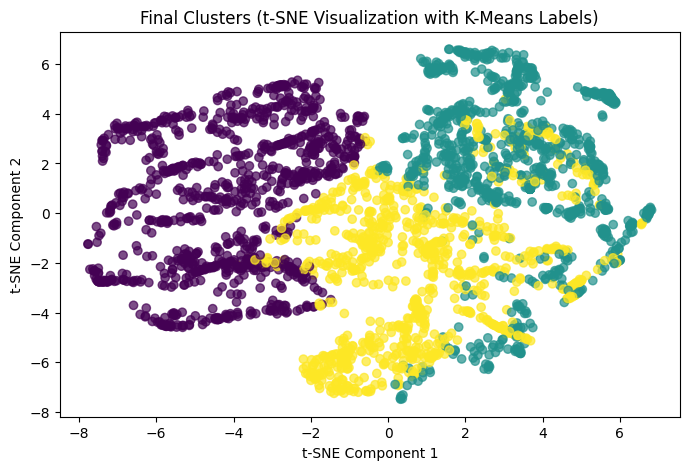

In [17]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
- Justify why certain clustering methods worked better.
- Relate findings to real-world clustering challenges.

Dimensionality reduction really helped in this project because it allowed us to take high-dimensional audio features and turn them into something we could actually see and interpret. Without reducing the dimensions, it would have been almost impossible to understand the structure of the data or to visualize the clusters.

K-Means worked better because it was able to find clear, well-separated clusters. The algorithm assumes that clusters are round and of similar size, which matched our data after dimensionality reduction. DBSCAN didn’t perform well in this case—it grouped most of the points into one big cluster and didn’t pick up the smaller groups. This shows that DBSCAN was sensitive to the distance settings and might need more tuning to work properly here.

In real-world clustering, it’s common to face challenges like noise, overlapping clusters, and choosing the right parameters for each method. This assignment shows why it’s important to test different clustering approaches and why dimensionality reduction is a powerful step to make complex data easier to work with.